# WIKIGENDER 
## todo: find fancy title

In [1]:
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext
from pyspark.sql.types import StringType
from pyspark.sql.functions import udf
#from createDataset.params import *
import os
import json
import pandas as pd

import matplotlib.pyplot as plt

In [2]:
LOCAL_PATH = "../data/"
WIKI_DATA = os.path.join(LOCAL_PATH, "wikipedia_male_female.json")

### Data extraction
Explain process of extraction of the data; combination of wikimedia and wikipedia; preprocessing steps.

In [3]:
# create the session
spark = SparkSession.builder.getOrCreate()

# create the context
sc = spark.sparkContext

# Load data frame
df = spark.read.json(WIKI_DATA)
df.show()

+--------+---------+--------------------+--------------------+--------------------+--------------------+
|  gender|       id|                name|          occupation|            overview|          wiki-title|
+--------+---------+--------------------+--------------------+--------------------+--------------------+
|Q6581097|Q26998233|       A. E. Pickard|                  []|Albert Ernest Pic...|       A. E. Pickard|
|Q6581097| Q4647941|       A. J. Masters|['Q177220', 'Q753...|Arthur John Masar...|       A. J. Masters|
|Q6581097| Q4648064|A. L. A. Himmelwr...|['Q13582652', 'Q8...|Abraham Lincoln A...|A. L. A. Himmelwr...|
|Q6581097| Q4647256|  A. N. Sattampillai|        ['Q1234713']|Arumai Nayakam Sa...|  A. N. Sattampillai|
|Q6581097|   Q84136|         A. Vellayan|          ['Q43845']|A. Vellayan (born...|         A. Vellayan|
|Q6581097|Q16030065|   A. W. Kjellstrand|        ['Q3246315']|August William Kj...|   A. W. Kjellstrand|
|Q6581097| Q4661199|    Aage Fahrenholtz|       ['Q1133

The previous table shows an example of the data we are working with. Each row represents the article of a given person with the following information associated:
- Name
- ID (wikimedia)
- Wiki-title (wikipedia)
- Gender
- Ocuppation
- Overview

In the following steps we are going to explore how women are represented in wikipedia. First, we will start with some basic statistics like the fraction of entries that correspond to each gender and how this varies along different occupations. After, we will enter in the core analysis of the project by analysing the language used to present the different characters. The idea is to focus on the adjectives used in the overviews and look for a bias between male and female representations. 
**ADD SOME MORE DETAILS AND INTRODUCTION**

## Data translation
Translate wikimedia codes to the actual meaning in terms of gender and occupation.
**Note:** Since we are interested in both gender and occupation, when the translation from wikimedia code to words is perform those people without associated occupation will be dropped from the dataset.

In [4]:
# Open Gender dictionary
with open('../data/dict_genders.json') as json_file:
    line = json_file.readline()
    dict_genders = json.loads(line)
    
# Open occupations dictionary
dict_occupations = {}
with open('../data/dict_occupations.json') as json_file:
    content = json_file.readlines()
    for line in content:
        occ = json.loads(line)
        dict_occupations.update(occ)
        
# Observation: We need dict_categories_occupations.json in the data folder
# Open occupations categories dictionary
with open('../data/dict_categories_occupations.json') as json_file:
    line = json_file.readline()
    dict_cat_occ = json.loads(line)

# Create function to translate a code into a category
def translate(mapping):
    def translate_(col):
        return mapping.get(col)
    return udf(translate_, StringType())

In [5]:
# Translate gender and occupations codes into corresponding labels
df = df.withColumn('gender', translate(dict_genders)('gender'))\
       .withColumn('occupation', explode(split(regexp_replace(regexp_replace(regexp_replace\
                                (regexp_replace(df['occupation'], '\\[', ''), '\\]', ''), ' ', ''),"'", ""), ",")))\
       .filter(col('occupation') != '')\
       .withColumn('occupation', translate(dict_occupations)('occupation'))\
       .withColumn('field', translate(dict_cat_occ)('occupation'))

df.show()

+------+---------+--------------------+--------------------+--------------------+--------------------+--------------+
|gender|       id|                name|          occupation|            overview|          wiki-title|         field|
+------+---------+--------------------+--------------------+--------------------+--------------------+--------------+
|  male| Q4647941|       A. J. Masters|              singer|Arthur John Masar...|       A. J. Masters|        Artist|
|  male| Q4647941|       A. J. Masters|          songwriter|Arthur John Masar...|       A. J. Masters|        Artist|
|  male| Q4648064|A. L. A. Himmelwr...|      civil engineer|Abraham Lincoln A...|A. L. A. Himmelwr...|          null|
|  male| Q4648064|A. L. A. Himmelwr...|            engineer|Abraham Lincoln A...|A. L. A. Himmelwr...|     Scientist|
|  male| Q4647256|  A. N. Sattampillai|          theologian|Arumai Nayakam Sa...|  A. N. Sattampillai|      Religion|
|  male|   Q84136|         A. Vellayan|      businessper

## TODO: solve display of table

### Gender distribution

In [7]:
# Query to know how many males and females are in the data frame
# Observation: When occupation translation is done, the observations without a label are dropped, that's why, there are less male and female
df.registerTempTable("df")

query = """
SELECT gender, count(DISTINCT id) as count
FROM df
GROUP BY gender
ORDER BY count DESC
"""

gender_counts = spark.sql(query)
gender_counts = gender_counts.toPandas()
gender_counts

,gender,count
0,male,1091472
1,female,218580


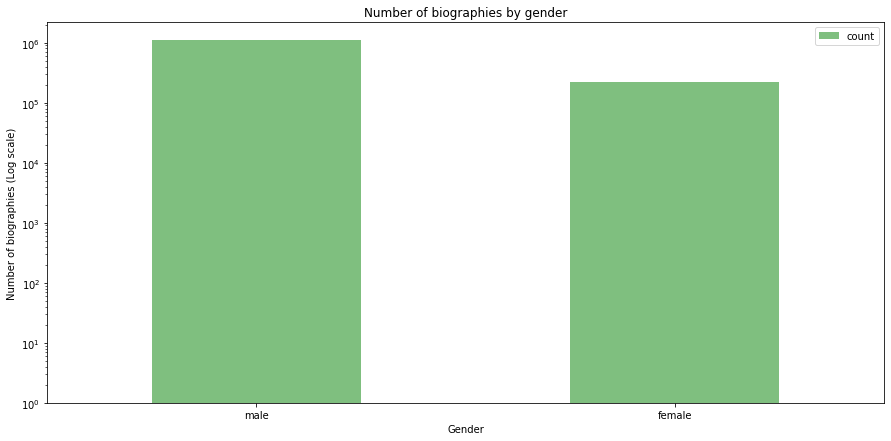

In [9]:
pl = gender_counts.plot(kind="bar", x="gender", y="count", figsize=(15, 7), log=True, \
                        alpha=0.5, color="green", rot=0)
pl.set_xlabel("Gender")
pl.set_ylabel("Number of biographies (Log scale)")
pl.set_title("Number of biographies by gender");

### Occupation distribution

In [10]:
df.registerTempTable("df")

query = """
SELECT field, count(DISTINCT id) as count
FROM df
WHERE field IS NOT NULL
GROUP BY field
ORDER BY count DESC
"""

occu_cat_counts = spark.sql(query)
occu_cat_counts = occu_cat_counts.toPandas()
occu_cat_counts.head()

,field,count
0,Sports,381505
1,Artist,351666
2,Politics,205882
3,Business & Law,82712
4,Social Sciences,77480


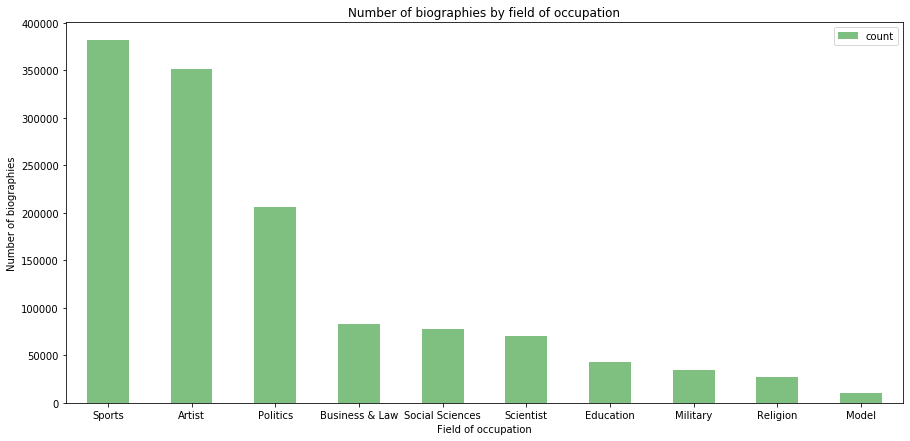

In [12]:
pl = occu_cat_counts.plot(kind="bar", x="field", y="count", figsize=(15, 7), log=False, \
                          alpha=0.5, color="green", rot=0)
pl.set_xlabel("Field of occupation")
pl.set_ylabel("Number of biographies")
pl.set_title("Number of biographies by field of occupation");

The most common occupation among our characters is **Sports** followed by **Artist** and **Politics**. The group **None** represents all those occupations that did not match any of the previous groups. 

In [14]:
n_total = occu_cat_counts['count'].sum()
n_sports = occu_cat_counts[occu_cat_counts['field'] == 'Sports']['count'].values[0]
n_artist = occu_cat_counts[occu_cat_counts['field'] == 'Artist']['count'].values[0]
n_politics = occu_cat_counts[occu_cat_counts['field'] == 'Politics']['count'].values[0]

print("{:.2f}% of the entries work in the sports field".format(n_sports/n_total*100))
print("{:.2f}% of the entries work in the artistic field".format(n_artist/n_total*100))
print("{:.2f}% of the entries work in the politics field".format(n_politics/n_total*100))

29.70% of the entries work in the sports field
27.38% of the entries work in the artistic field
16.03% of the entries work in the politics field


### Gender by occupation

How are the distinct genders represented within the different occupational groups? Is there any group where women have a greater representation than men?

In [15]:
df.registerTempTable("df")

query = """
SELECT field, gender, count(DISTINCT id) as count
FROM df
WHERE field IS NOT NULL
GROUP BY field, gender
ORDER BY field, gender
"""

occu_gender_counts = spark.sql(query)
occu_gender_counts = occu_gender_counts.toPandas()
occu_gender_counts.head()

,field,gender,count
0,Artist,female,94761
1,Artist,male,256905
2,Business & Law,female,7591
3,Business & Law,male,75121
4,Education,female,6749


From the plot we can point out different details: 
- Female biographies are less in all fields except **Model** which is associated to the mode industry. In this case, for each 5 biographies related to female characters we have one male biography.
- **Religion** and **Military** are the groups where the ratio female:male becomes larger. In religion related biographies for each female we will find 69 males. In military related ones, for each female we will find 62 males.
- The most balanced occupational field is **Artist** where the ratio female:male is of 1:3"
   

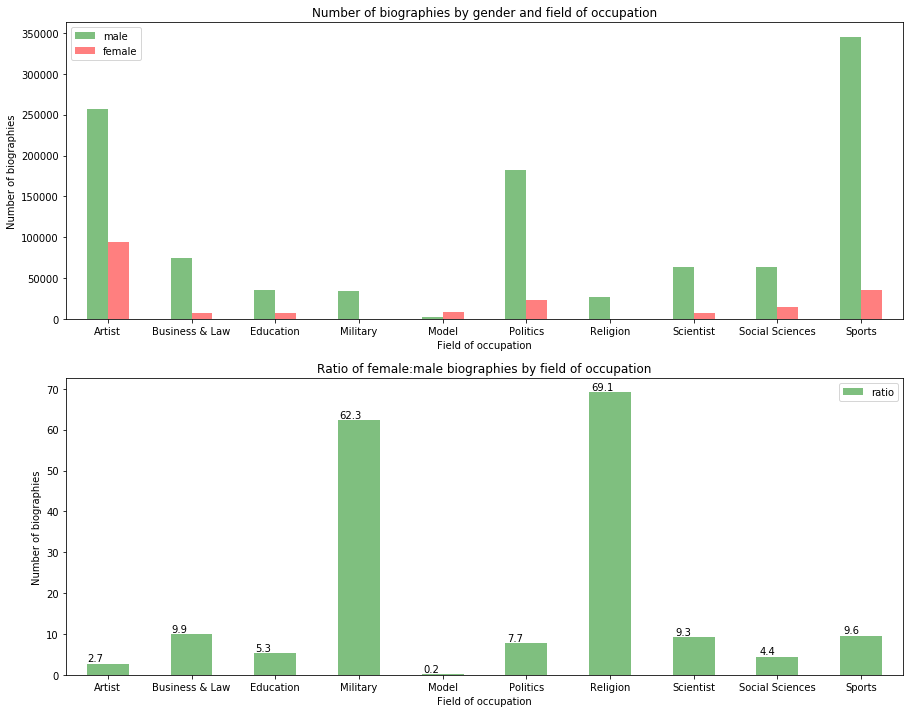

In [21]:
male_count = occu_gender_counts[occu_gender_counts['gender'] == 'male']['count'].tolist()
female_count = occu_gender_counts[occu_gender_counts['gender'] == 'female']['count'].tolist()
index = occu_gender_counts['field'].unique().tolist()
occ_by_gender = pd.DataFrame({'male': male_count, 'female': female_count}, index=index)

fig, ax = plt.subplots(2, 1, figsize=(15, 12))
pl = occ_by_gender.plot(kind="bar", log=False, alpha=0.5, color=["green", "red"], rot=0, ax=ax[0])
pl.set_xlabel("Field of occupation")
pl.set_ylabel("Number of biographies")
pl.set_title("Number of biographies by gender and field of occupation");
             
occ_by_gender['ratio'] = occ_by_gender.apply(lambda x: x.male / x.female, axis=1)
pl = occ_by_gender.plot(kind="bar", y='ratio', alpha=0.5, color='green', rot=0, ax=ax[1])
for p in ax[1].patches:
    disp= '{:.1f}'.format(p.get_height())
    ax[1].annotate(disp, (p.get_x() * 1.005, p.get_height() +0.5))
pl.set_xlabel("Field of occupation")
pl.set_ylabel("Number of biographies")
pl.set_title("Ratio of female:male biographies by field of occupation");